# Compare vaccination strategies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from plot_utils import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'equal'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'no vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'THL Pop, inf, hosp'),
    ('thl', [1/2, 1/2, 0], 'THL Pop and hosp'),
    ('thl', [1/2, 0, 1/2], 'THL Pop and inf'),
    ('thl', [0, 1/2, 1/2], 'THL Hosp and inf'),
    ('thl', [0, 1, 0], 'THL Hosp only'),
    ('thl', [0, 0, 1], 'THL Inf only'),
]

In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=True,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0)

Finished R: 1.0. 1/3. Policy: equal. 1/8
Finished R: 1.0. 1/3. Policy: no vaccination. 2/8
Finished R: 1.0. 1/3. Policy: THL Pop, inf, hosp. 3/8
Finished R: 1.0. 1/3. Policy: THL Pop and hosp. 4/8
Finished R: 1.0. 1/3. Policy: THL Pop and inf. 5/8
Finished R: 1.0. 1/3. Policy: THL Hosp and inf. 6/8
Finished R: 1.0. 1/3. Policy: THL Hosp only. 7/8
Finished R: 1.0. 1/3. Policy: THL Inf only. 8/8
Finished R: 1.25. 2/3. Policy: equal. 1/8
Finished R: 1.25. 2/3. Policy: no vaccination. 2/8
Finished R: 1.25. 2/3. Policy: THL Pop, inf, hosp. 3/8
Finished R: 1.25. 2/3. Policy: THL Pop and hosp. 4/8
Finished R: 1.25. 2/3. Policy: THL Pop and inf. 5/8
Finished R: 1.25. 2/3. Policy: THL Hosp and inf. 6/8
Finished R: 1.25. 2/3. Policy: THL Hosp only. 7/8
Finished R: 1.25. 2/3. Policy: THL Inf only. 8/8
Finished R: 1.5. 3/3. Policy: equal. 1/8
Finished R: 1.5. 3/3. Policy: no vaccination. 2/8
Finished R: 1.5. 3/3. Policy: THL Pop, inf, hosp. 3/8
Finished R: 1.5. 3/3. Policy: THL Pop and hosp. 4/8
F

In [4]:
def plot_results(ax, r, metric, all_results, t0, T, skip_no_vacc=True):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    x = [begin + datetime.timedelta(days=day) for day in range(T)]

    results_for_r = all_results[r]
    totals = []
    for label, results_all_metrics in results_for_r:
        if label == 'no vaccination' and skip_no_vacc:
            continue
        metric_results = results_all_metrics[metric]
        metric_all_time = metric_results.sum(axis=0)
        metric_all_time = metric_all_time.sum(axis=0)
        
        assert metric_all_time.shape[0] == T
        
        ax.plot(x, metric_all_time, label=label)
        total_policy = metric_all_time.sum(axis=0)
        total = (label, total_policy)
        totals.append(total)
        
    sorted_totals = sorted(totals, key=lambda x: x[-1])
    for total in sorted_totals:
        print('%s: %s' % (total[0], total[1]))
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s.' % (metric, ))
    ax.set_title('Number of %s per policy. R=%s' % (metric, r))
    ax.legend()
        
    return ax

# Deaths

THL Pop and inf: 8887.339909258999
THL Pop and hosp: 8888.914567827835
THL Pop, inf, hosp: 8889.408236277703
equal: 8891.298913368637
THL Hosp and inf: 8897.986780441826
THL Inf only: 8898.043989272484
THL Hosp only: 8900.777550672103


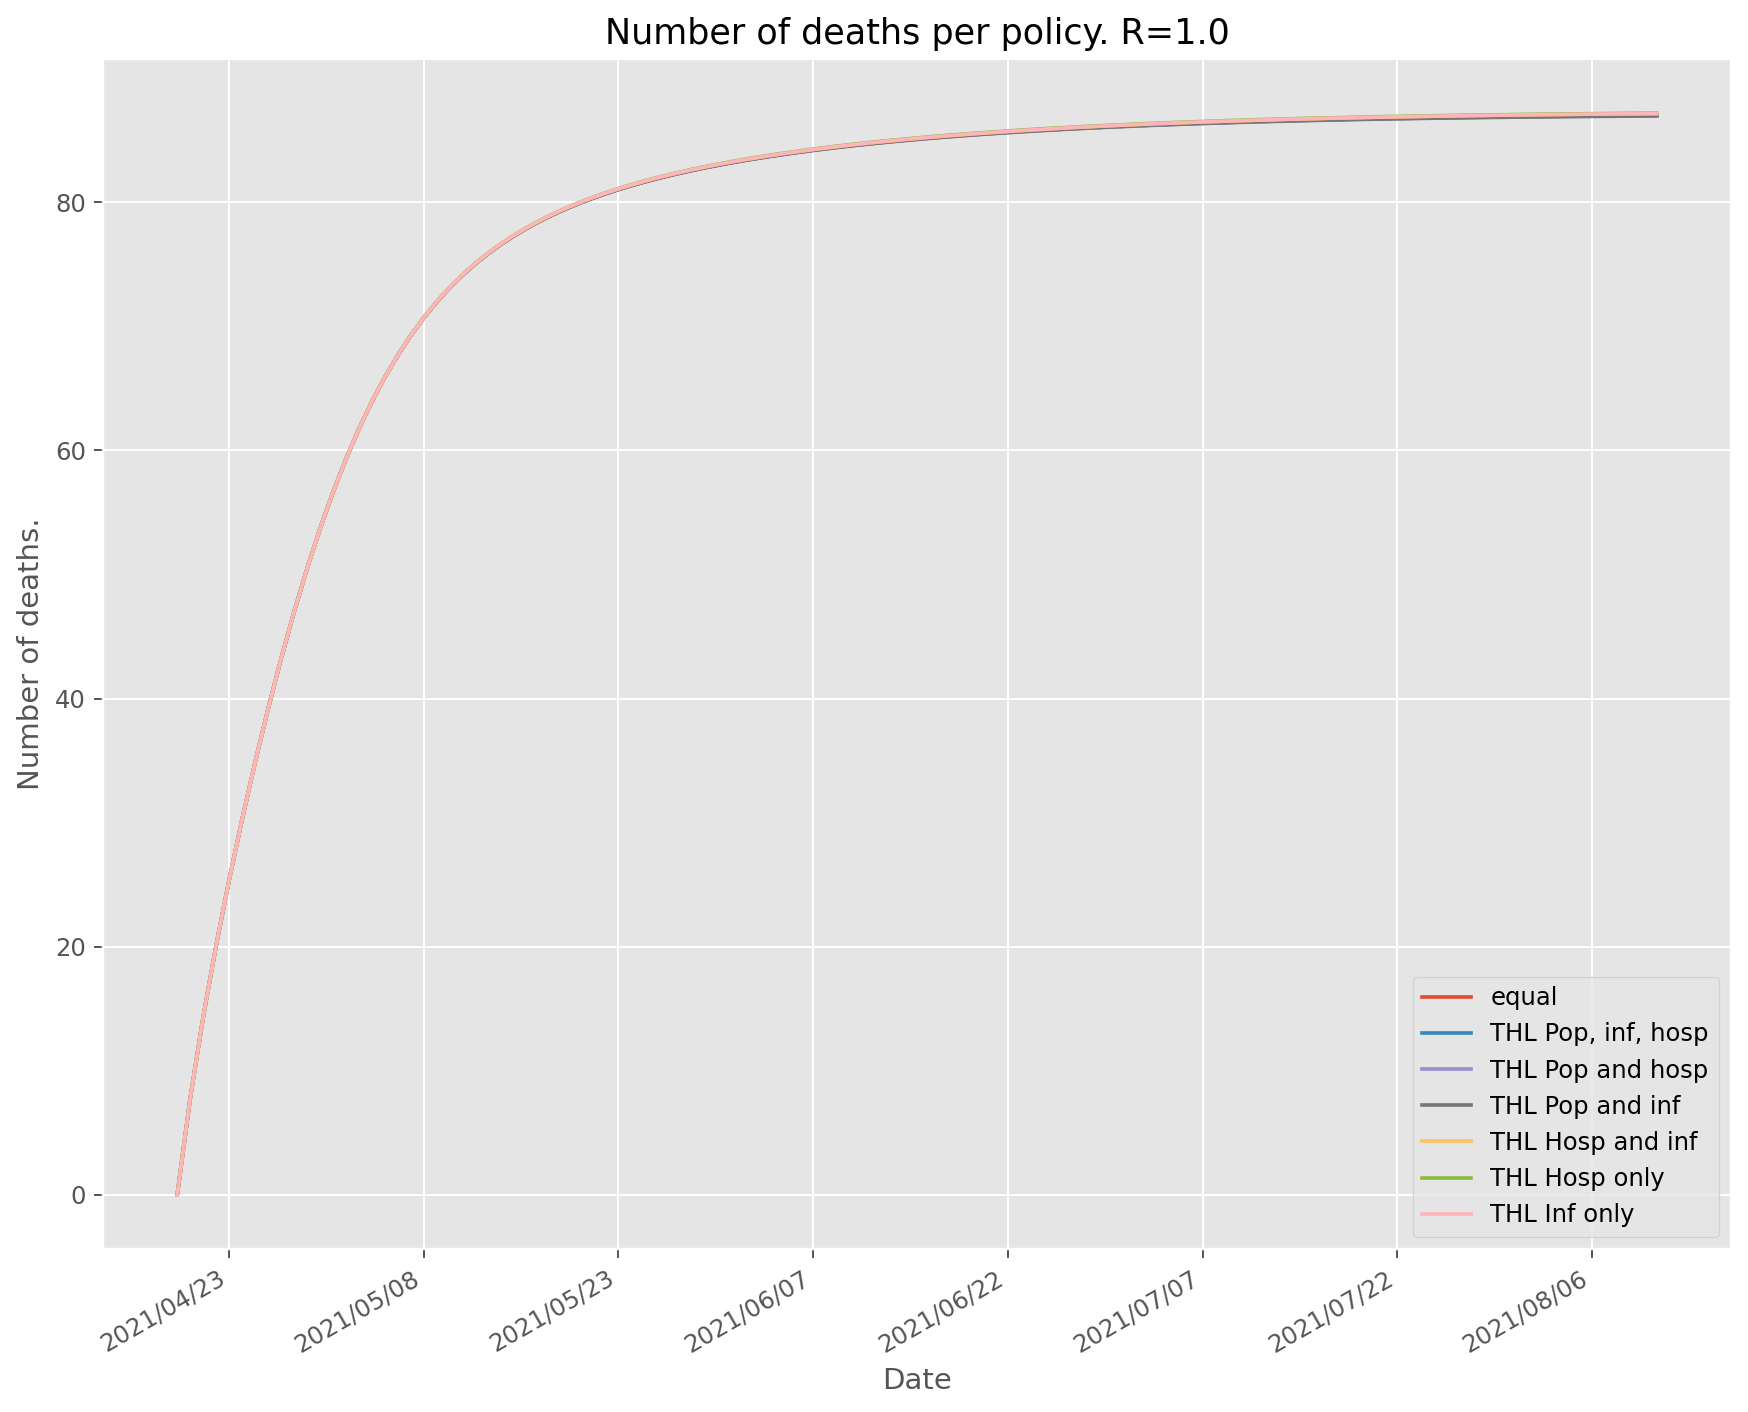

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

THL Pop and inf: 10029.307543544224
THL Pop and hosp: 10032.853195499263
THL Pop, inf, hosp: 10036.489782111685
equal: 10041.417790828496
THL Hosp and inf: 10068.199338492494
THL Inf only: 10069.338987392015
THL Hosp only: 10073.422436917926


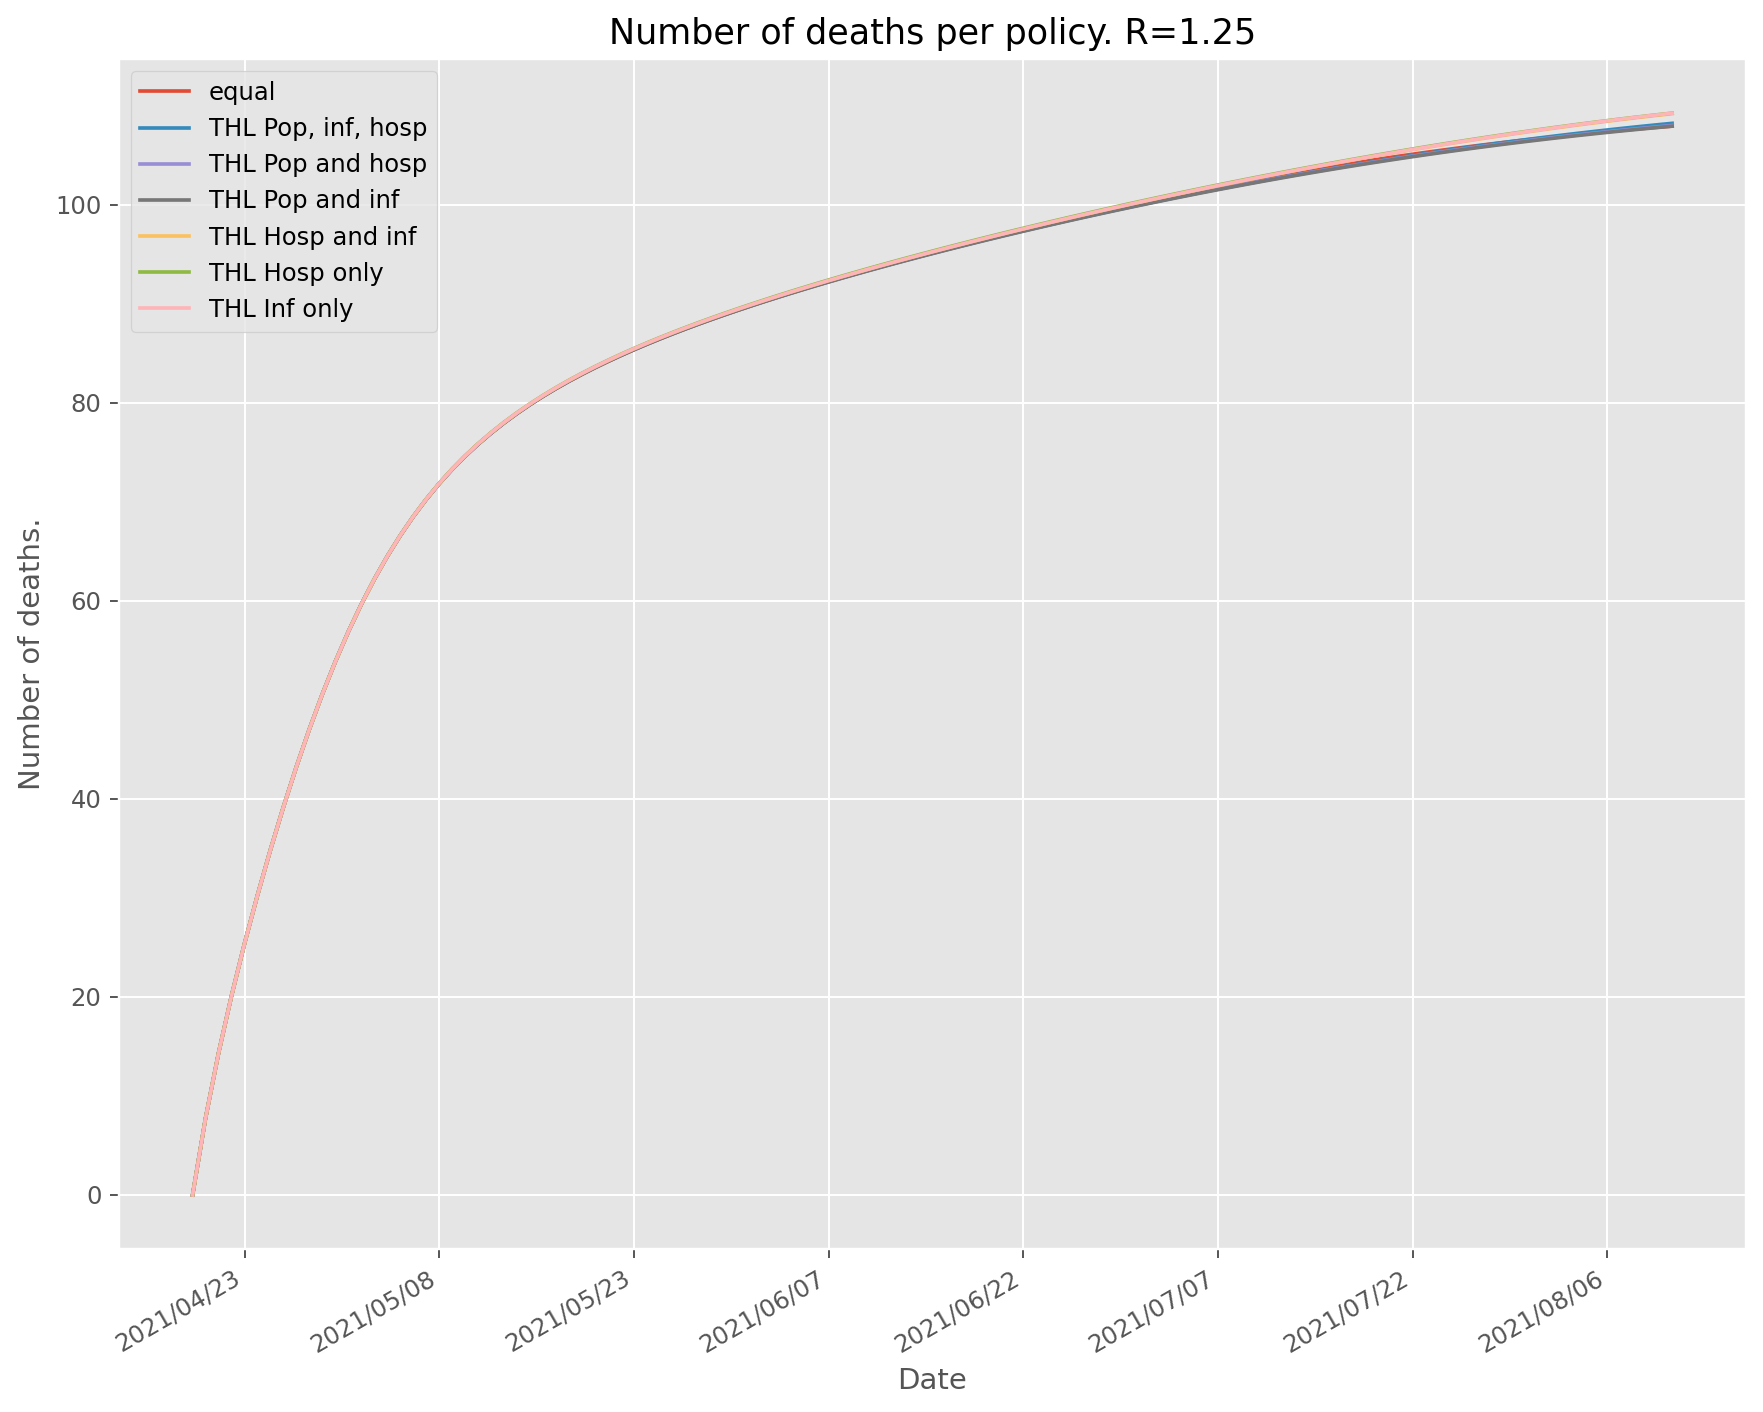

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

equal: 13062.34149564324
THL Pop and inf: 13072.36481698942
THL Pop and hosp: 13081.93670521609
THL Pop, inf, hosp: 13113.336509579678
THL Hosp and inf: 13256.46664026405
THL Inf only: 13263.354687853682
THL Hosp only: 13264.422328859


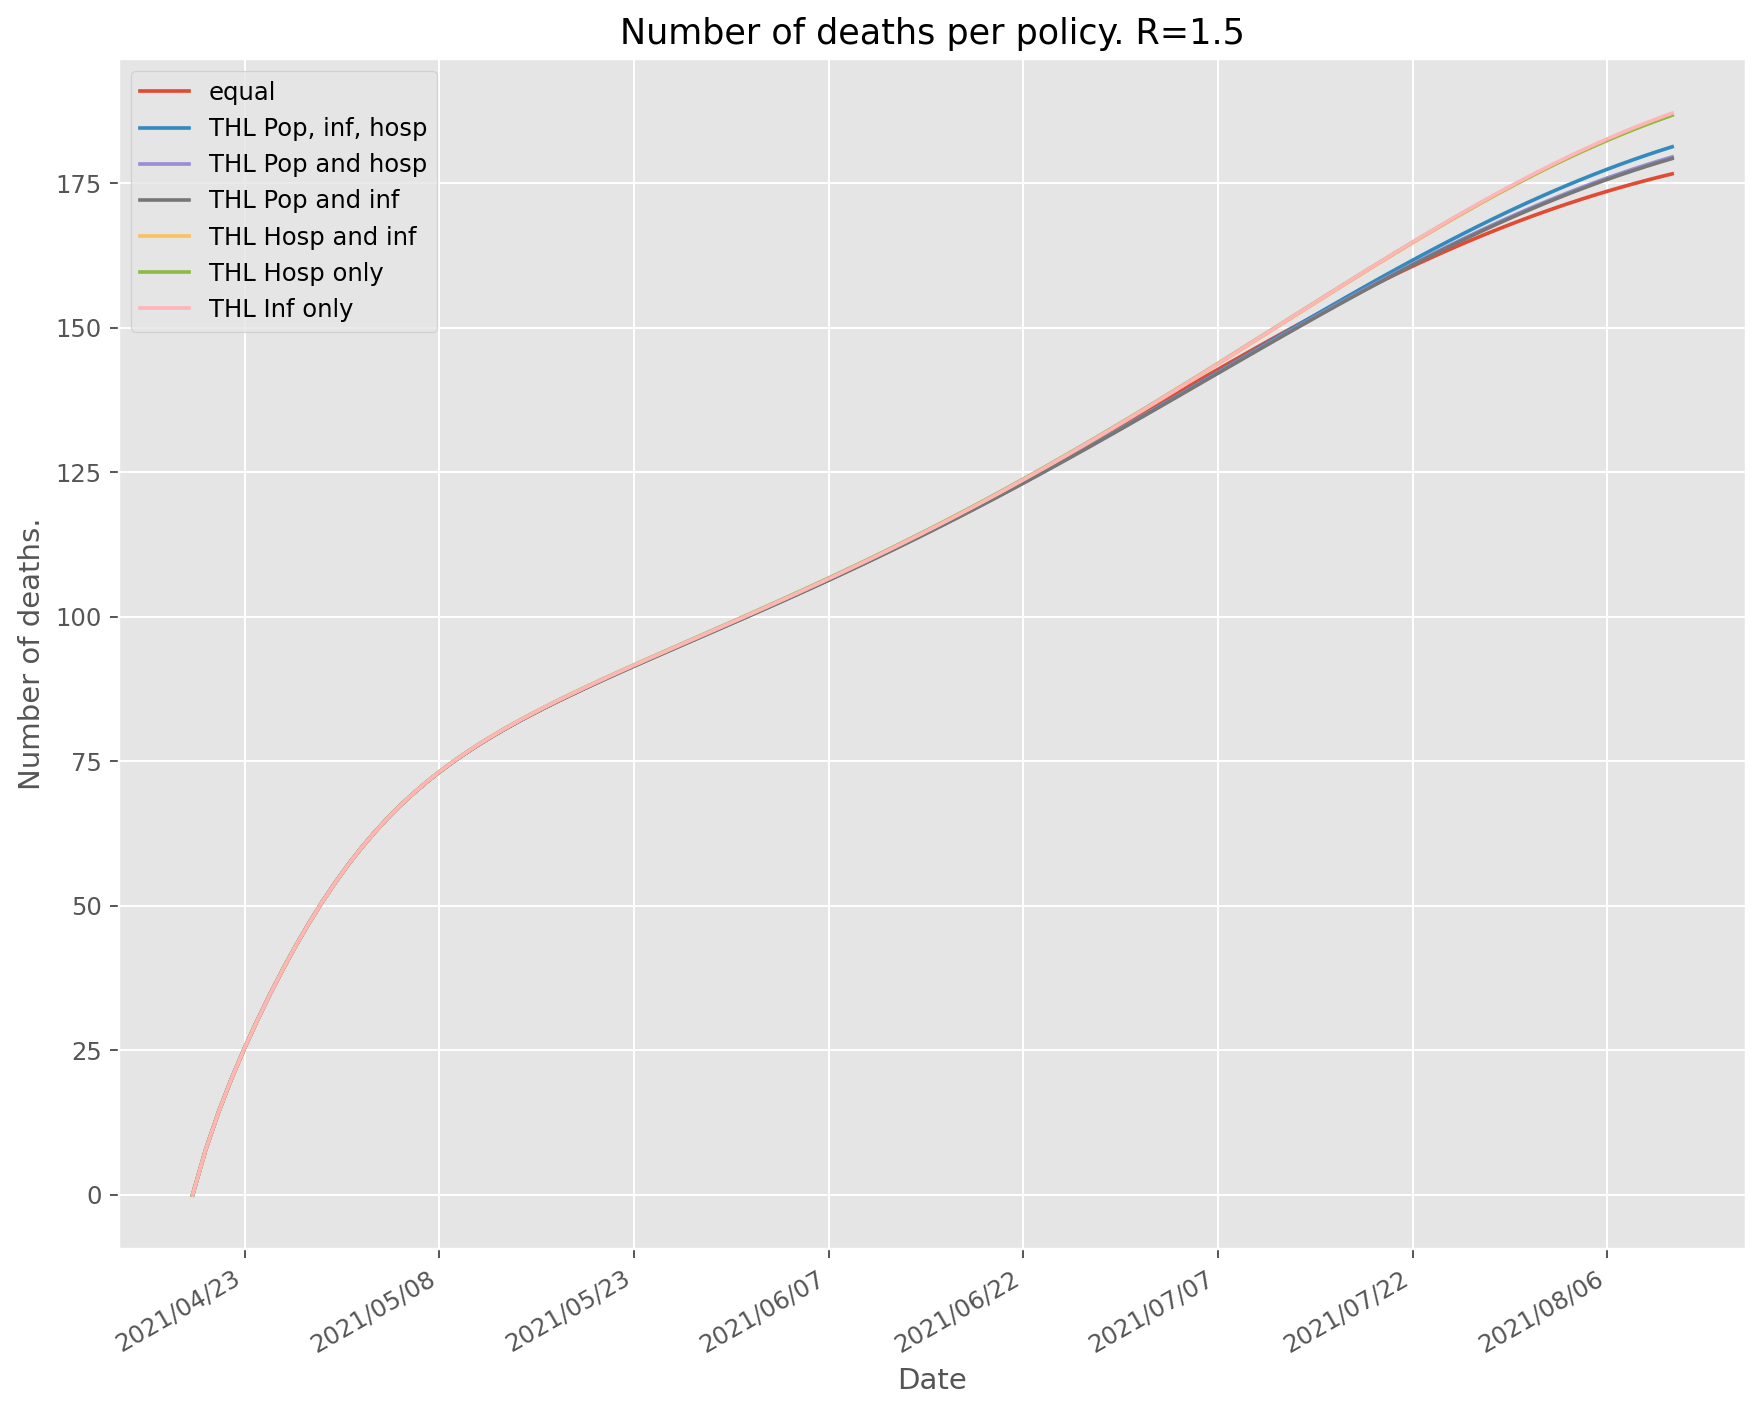

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Hospitalizations

THL Inf only: 7141.659399142011
THL Hosp and inf: 7143.574407408708
THL Hosp only: 7149.408730372722
THL Pop, inf, hosp: 7155.745362200662
THL Pop and inf: 7176.425891927405
THL Pop and hosp: 7179.263414856868
equal: 7326.884694994059


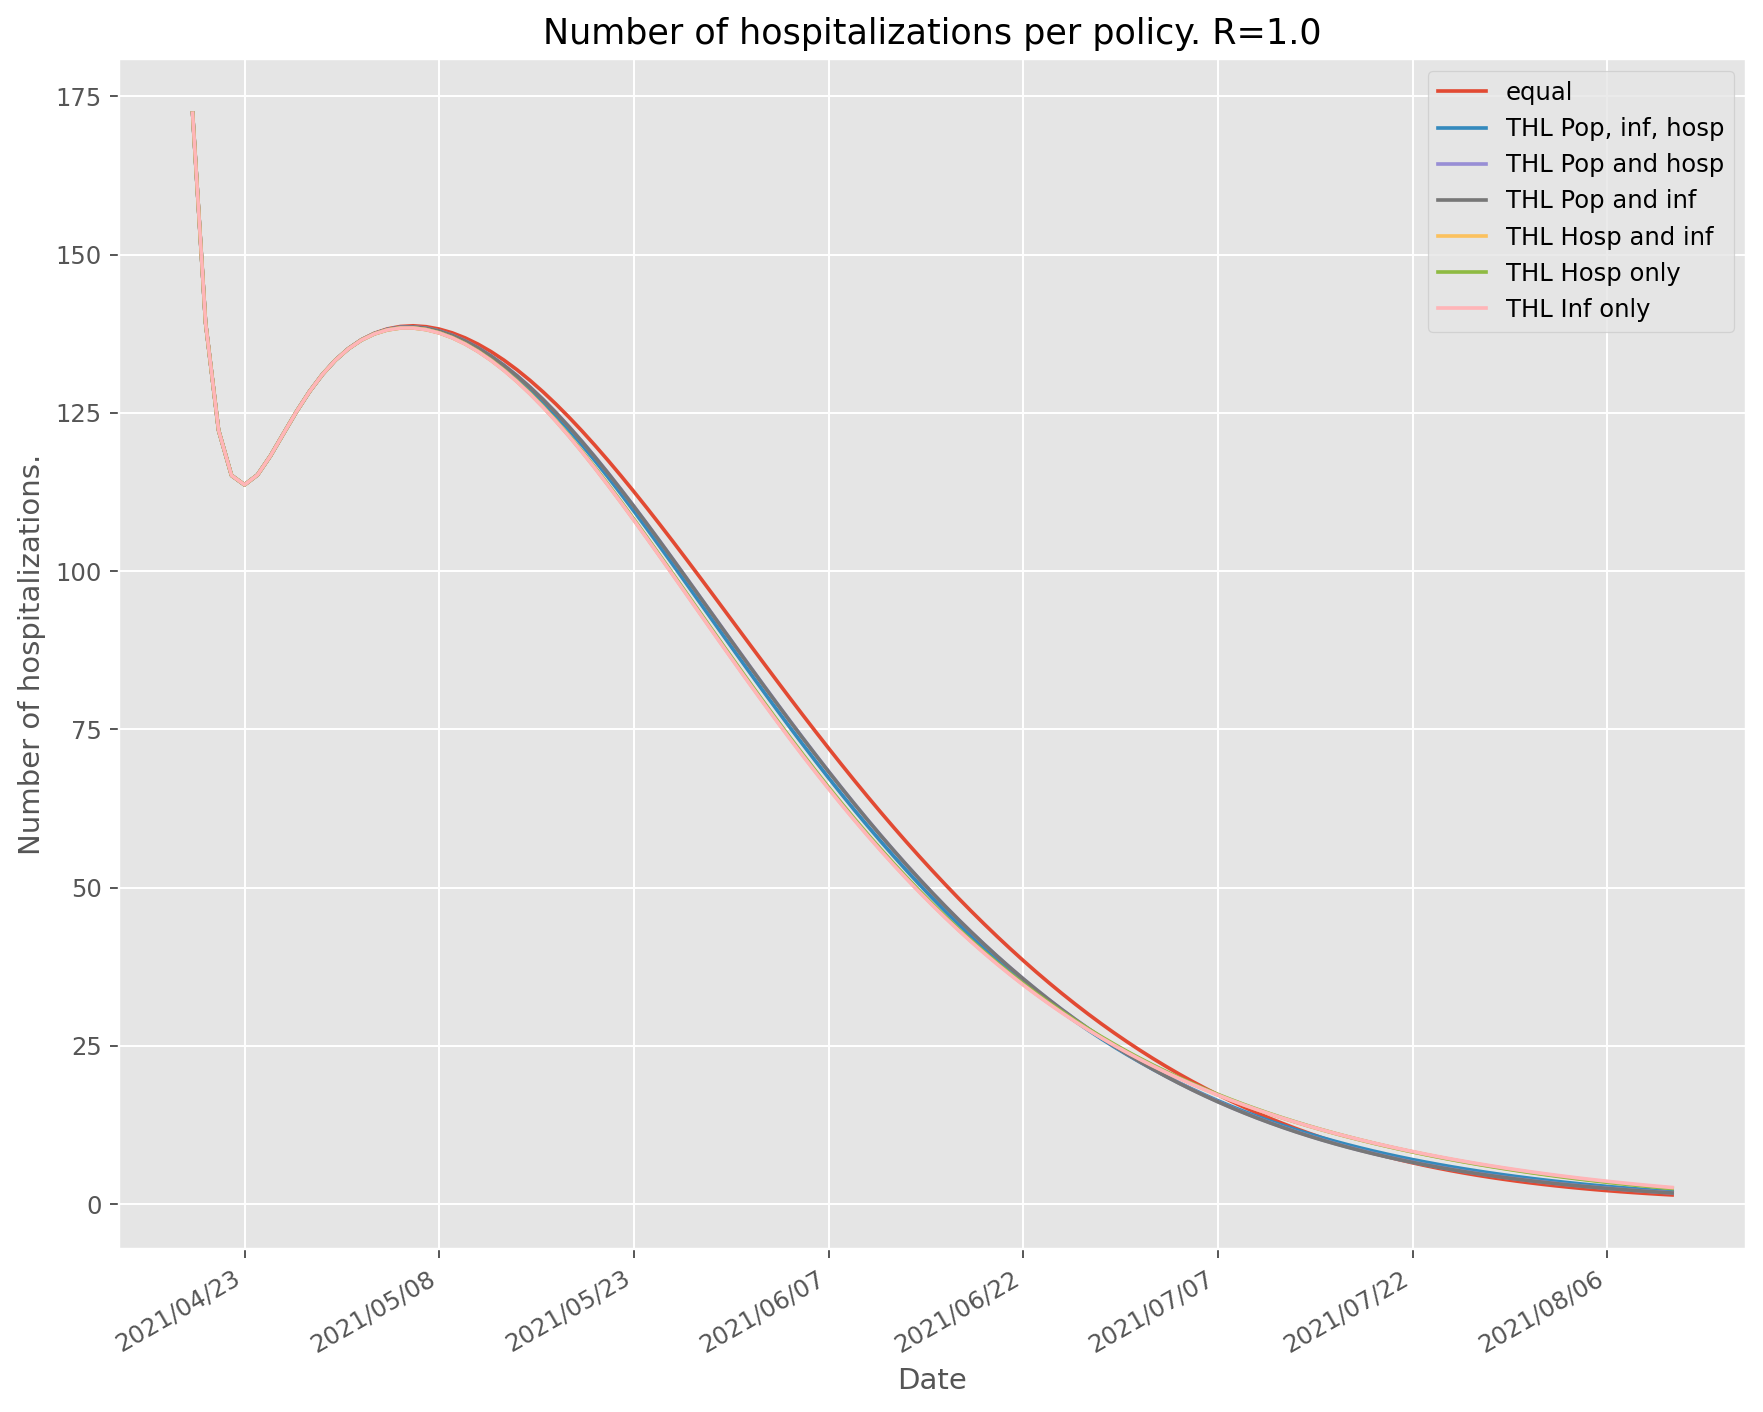

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

THL Pop and inf: 17577.95082563463
THL Pop and hosp: 17598.971538569884
THL Pop, inf, hosp: 17680.758563165567
equal: 17946.605485499746
THL Hosp only: 18075.6313506977
THL Hosp and inf: 18076.026912847716
THL Inf only: 18110.62744987632


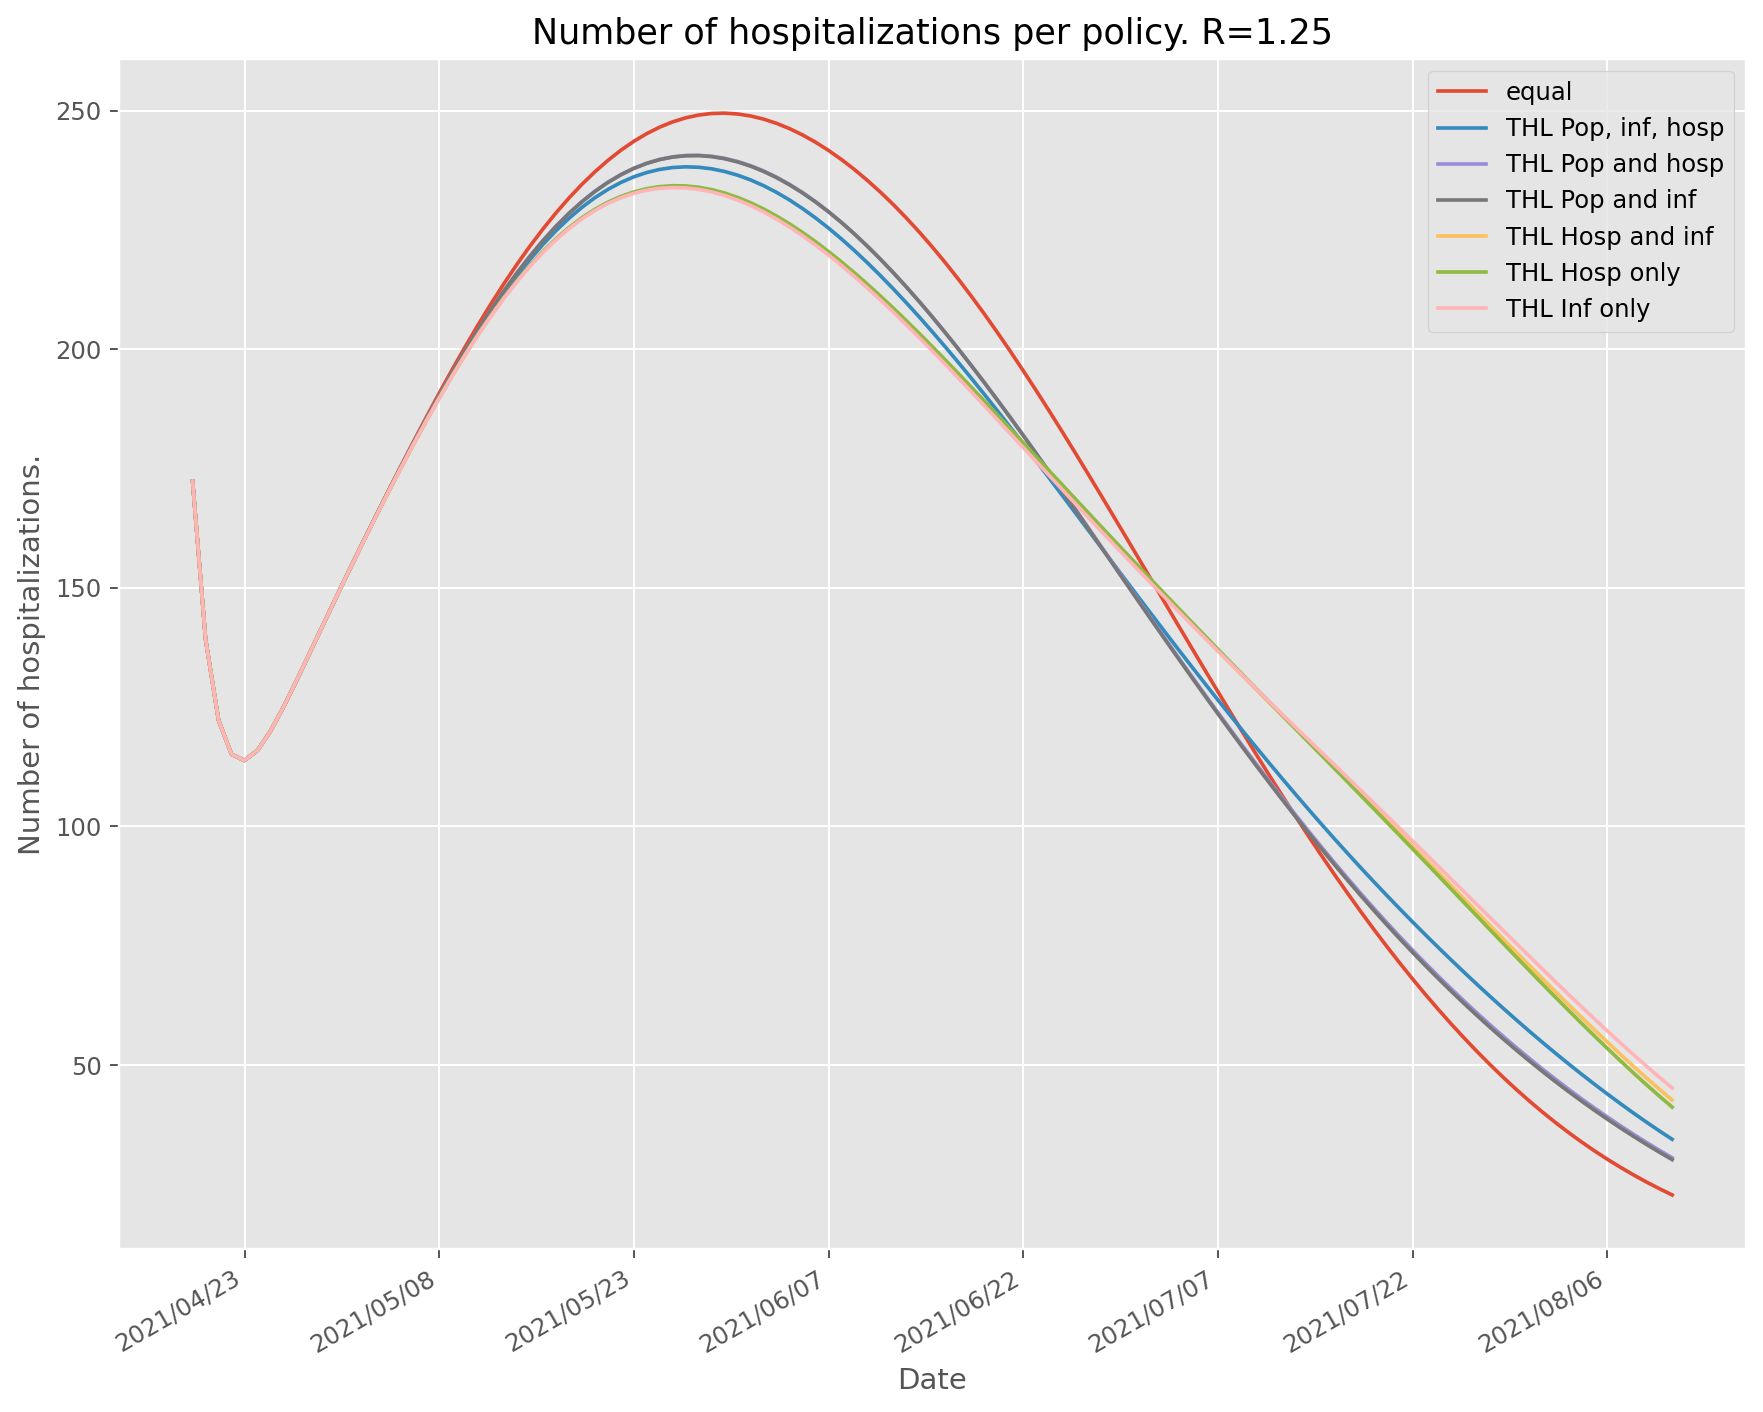

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

equal: 50834.37796323061
THL Pop and inf: 51417.0903139068
THL Pop and hosp: 51555.43027008377
THL Pop, inf, hosp: 52559.928397130665
THL Hosp only: 55396.420120086084
THL Hosp and inf: 55502.44785664808
THL Inf only: 55780.01650987066


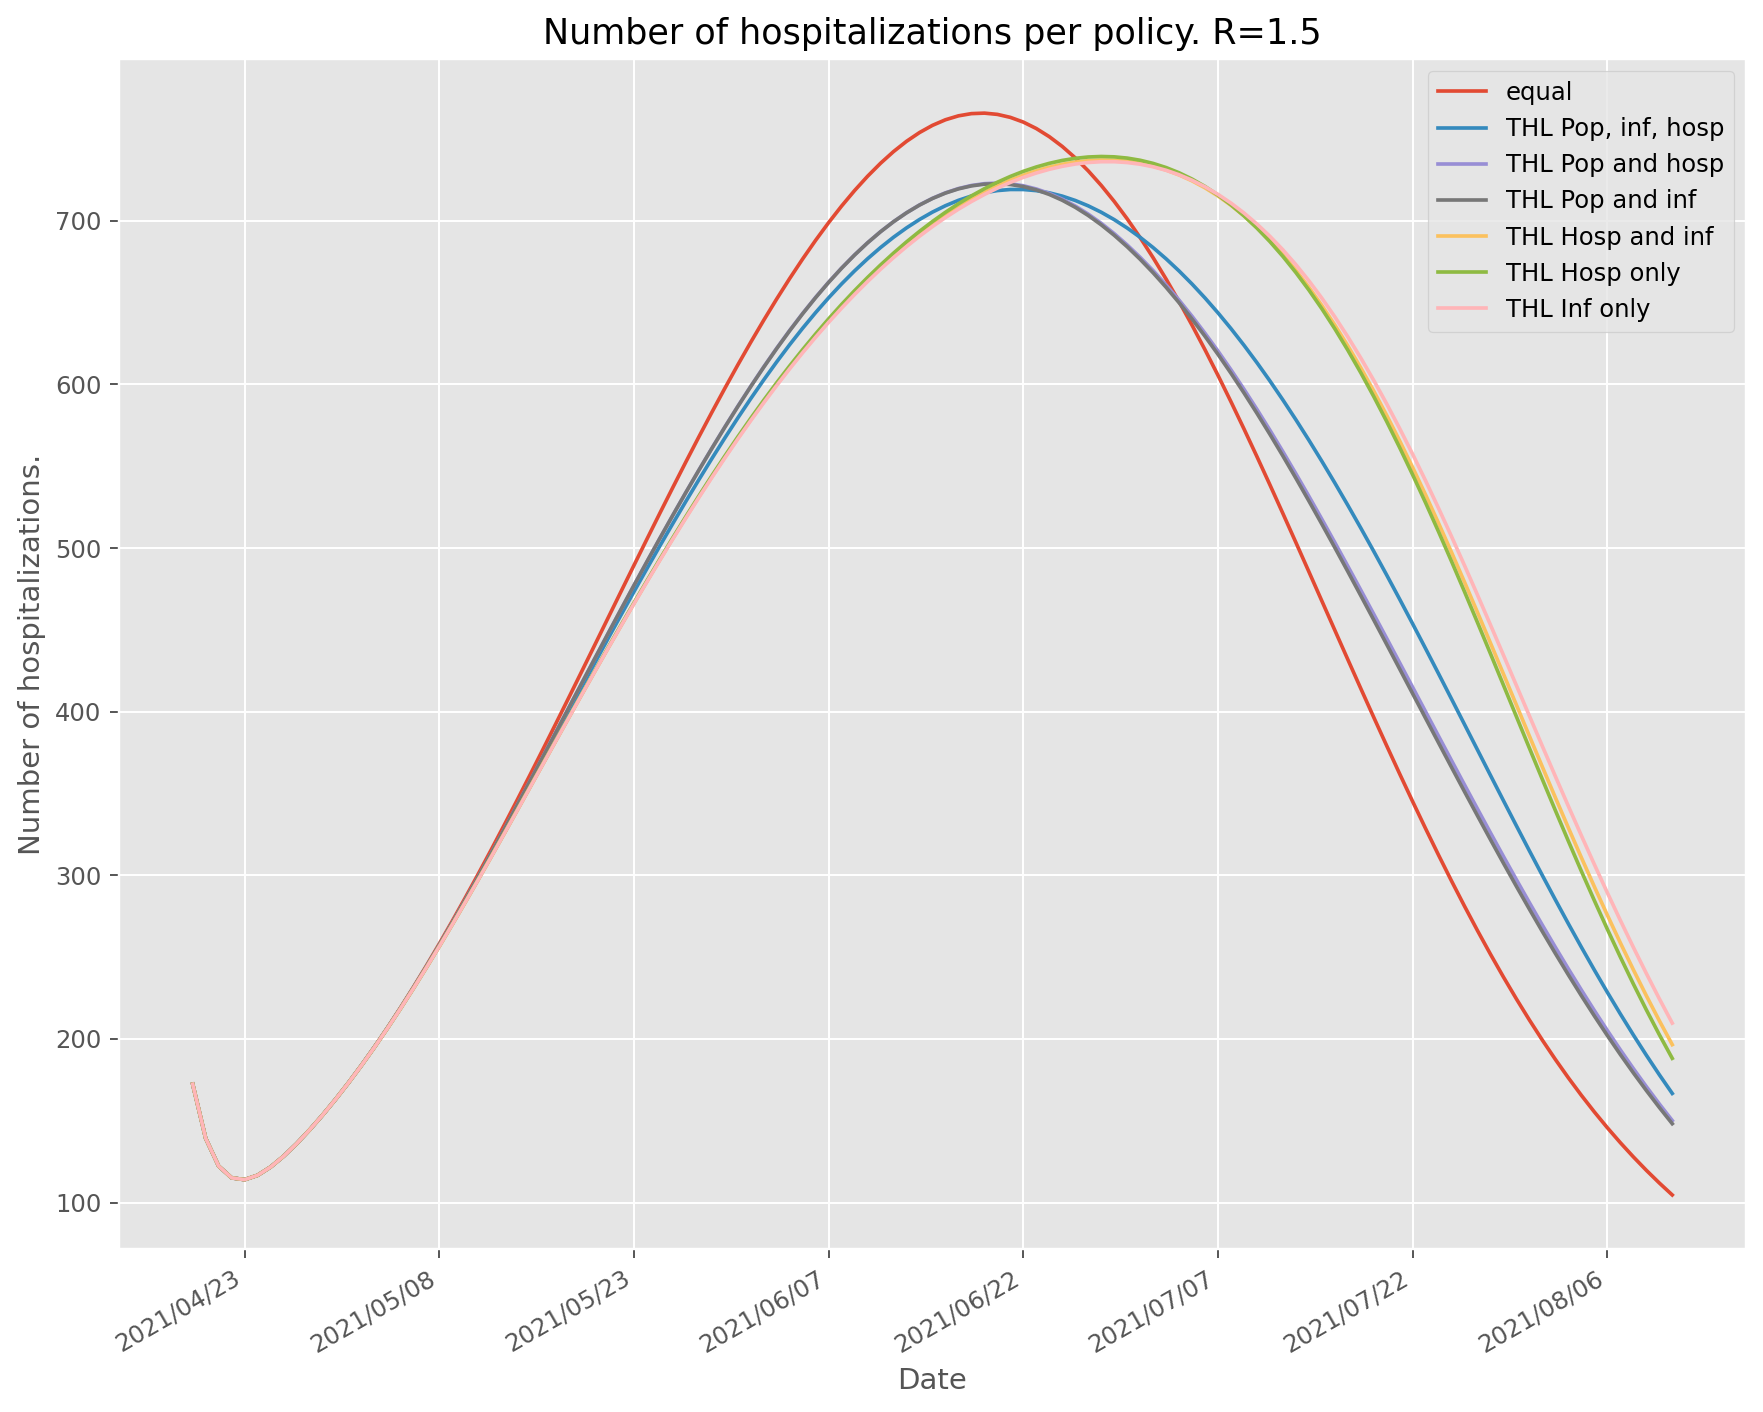

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Infections

THL Inf only: 189254.7574574367
THL Hosp and inf: 189275.77770721135
THL Hosp only: 189305.73982601578
THL Pop, inf, hosp: 191245.7554975756
THL Pop and hosp: 192315.54582028394
THL Pop and inf: 192366.94397176825
equal: 196797.4640007659


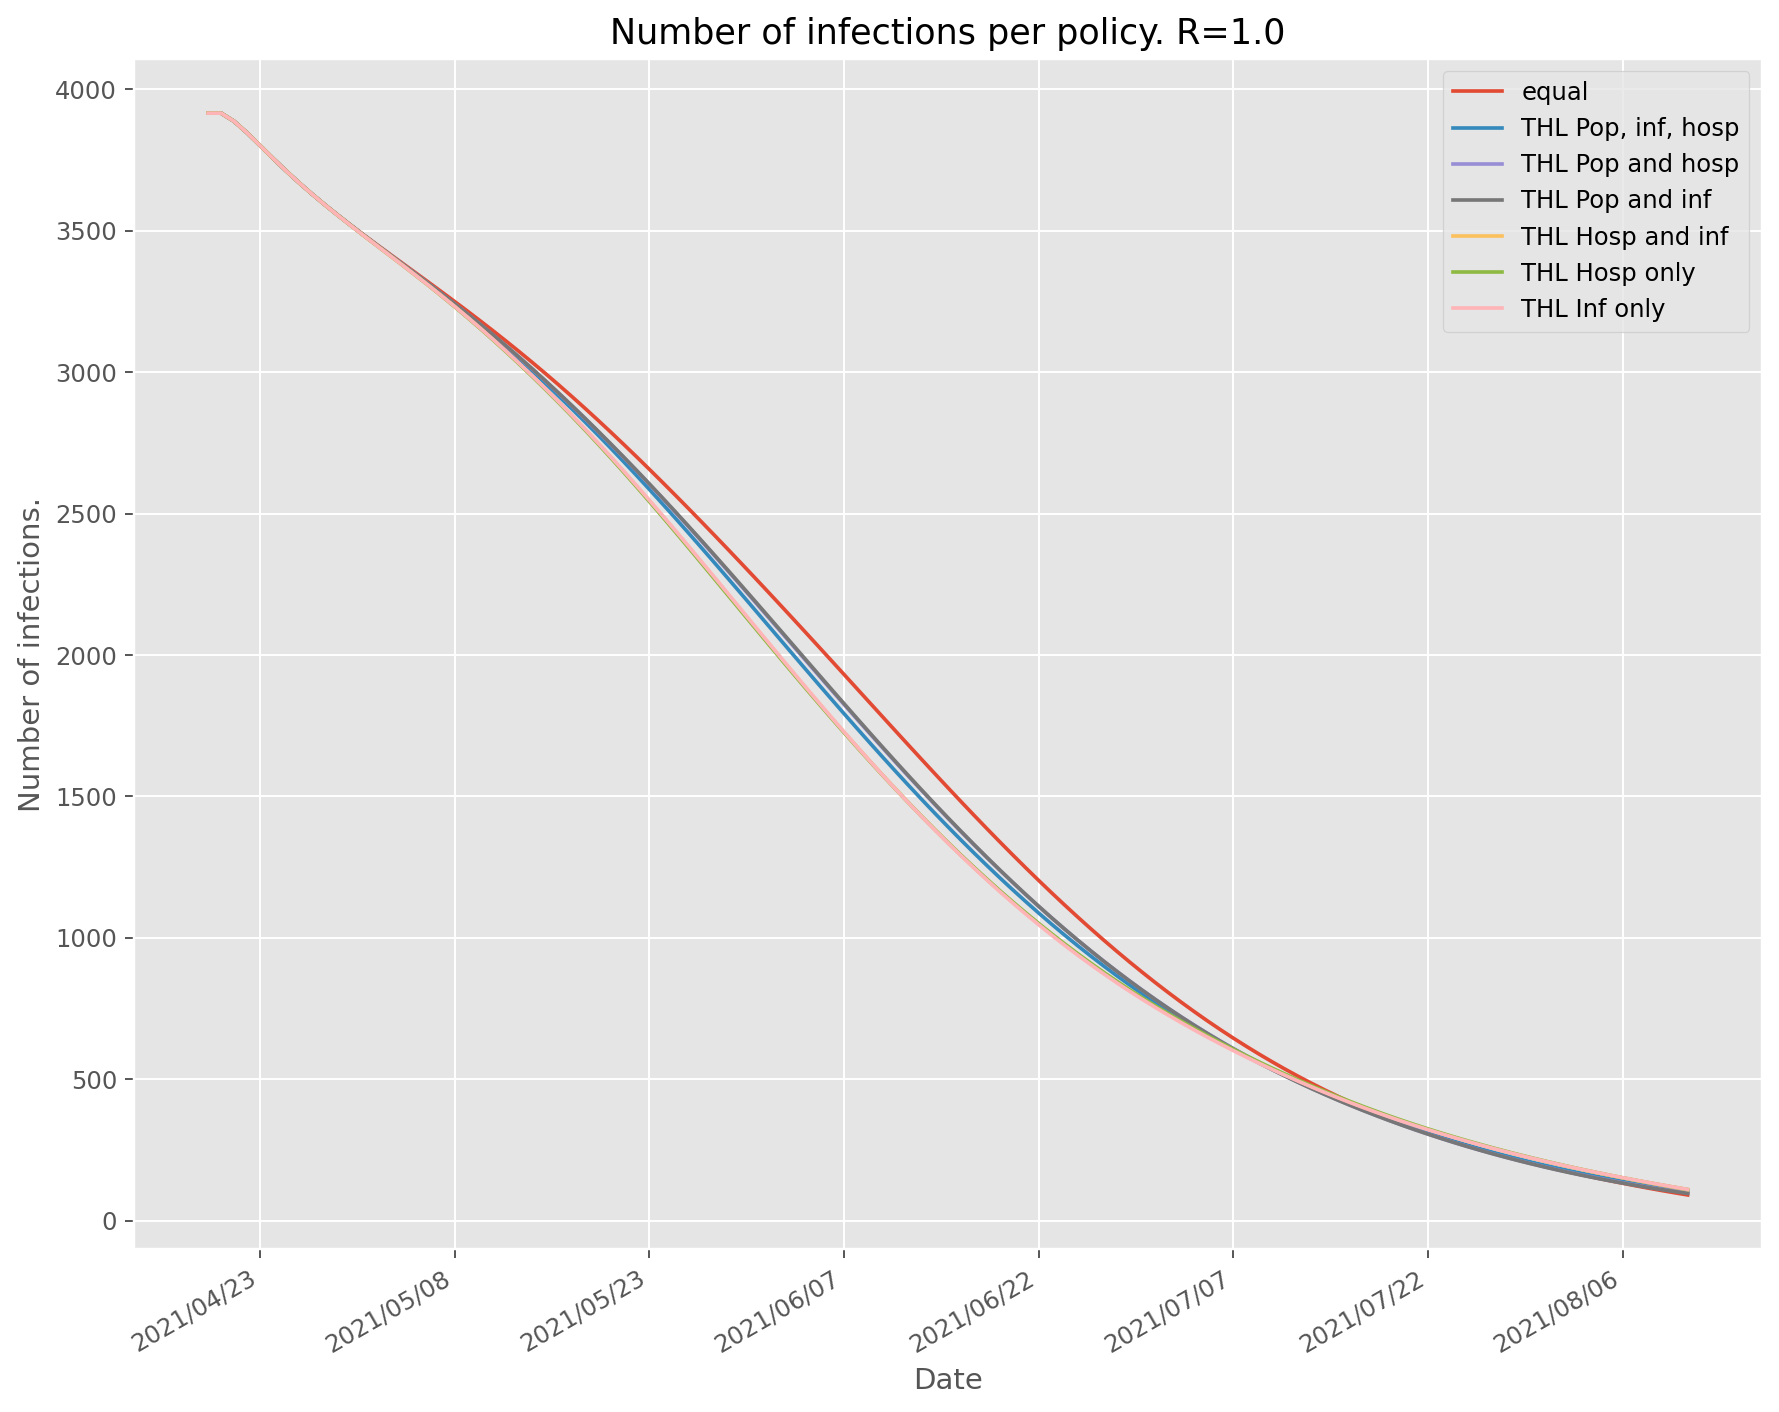

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

THL Inf only: 656666.6039955509
THL Hosp and inf: 656766.5773761615
THL Hosp only: 657450.4694458025
THL Pop, inf, hosp: 658263.4151957241
THL Pop and inf: 659071.7953221762
THL Pop and hosp: 659584.7504746333
equal: 674285.4432015233


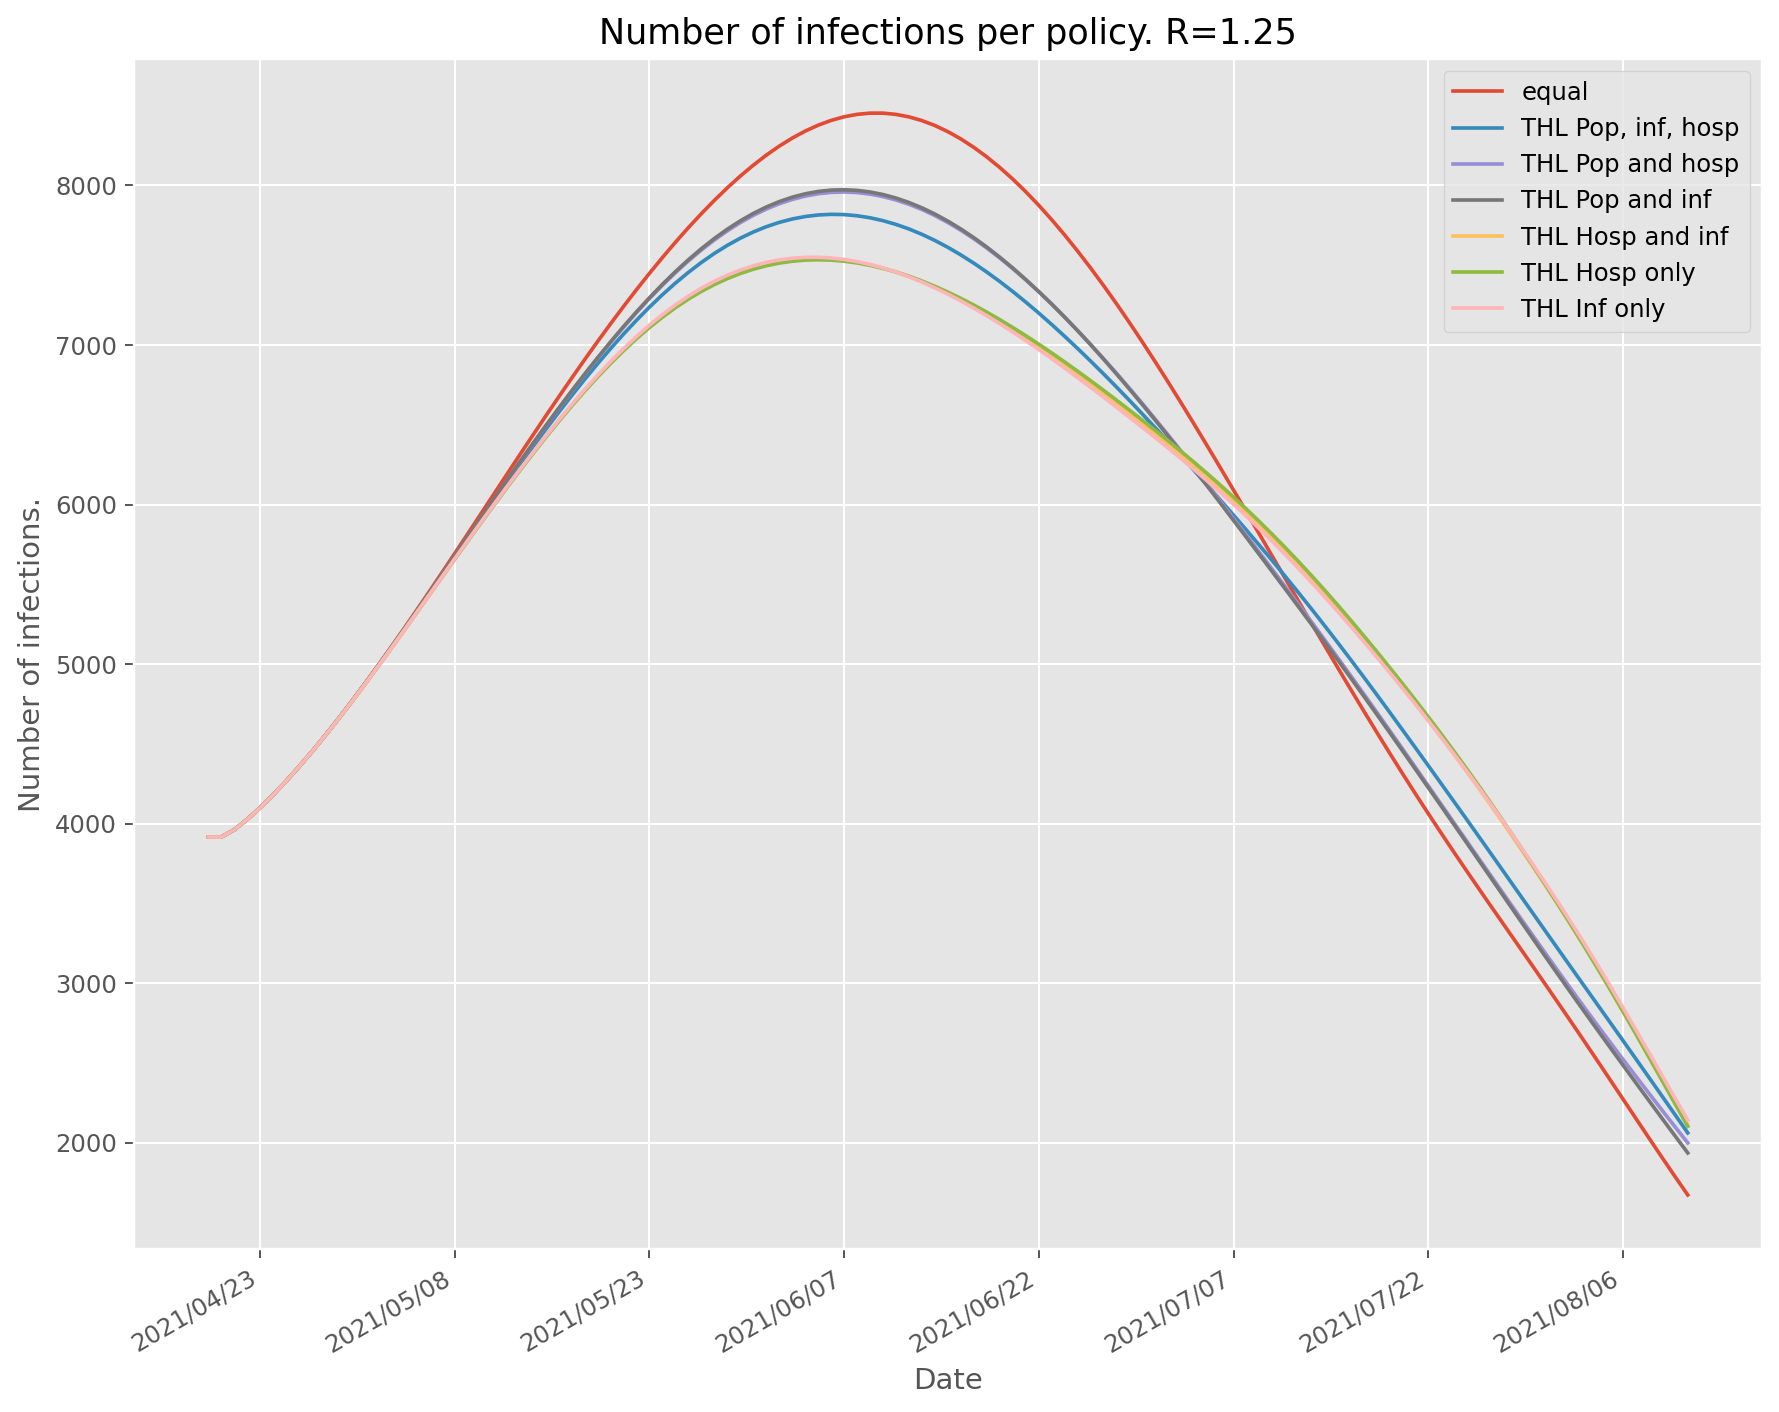

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

equal: 2241421.784794704
THL Pop and inf: 2244491.2405970716
THL Pop and hosp: 2249539.2046209383
THL Pop, inf, hosp: 2257951.6438403246
THL Hosp and inf: 2274307.6377850613
THL Hosp only: 2274533.9958222867
THL Inf only: 2276995.9390919833


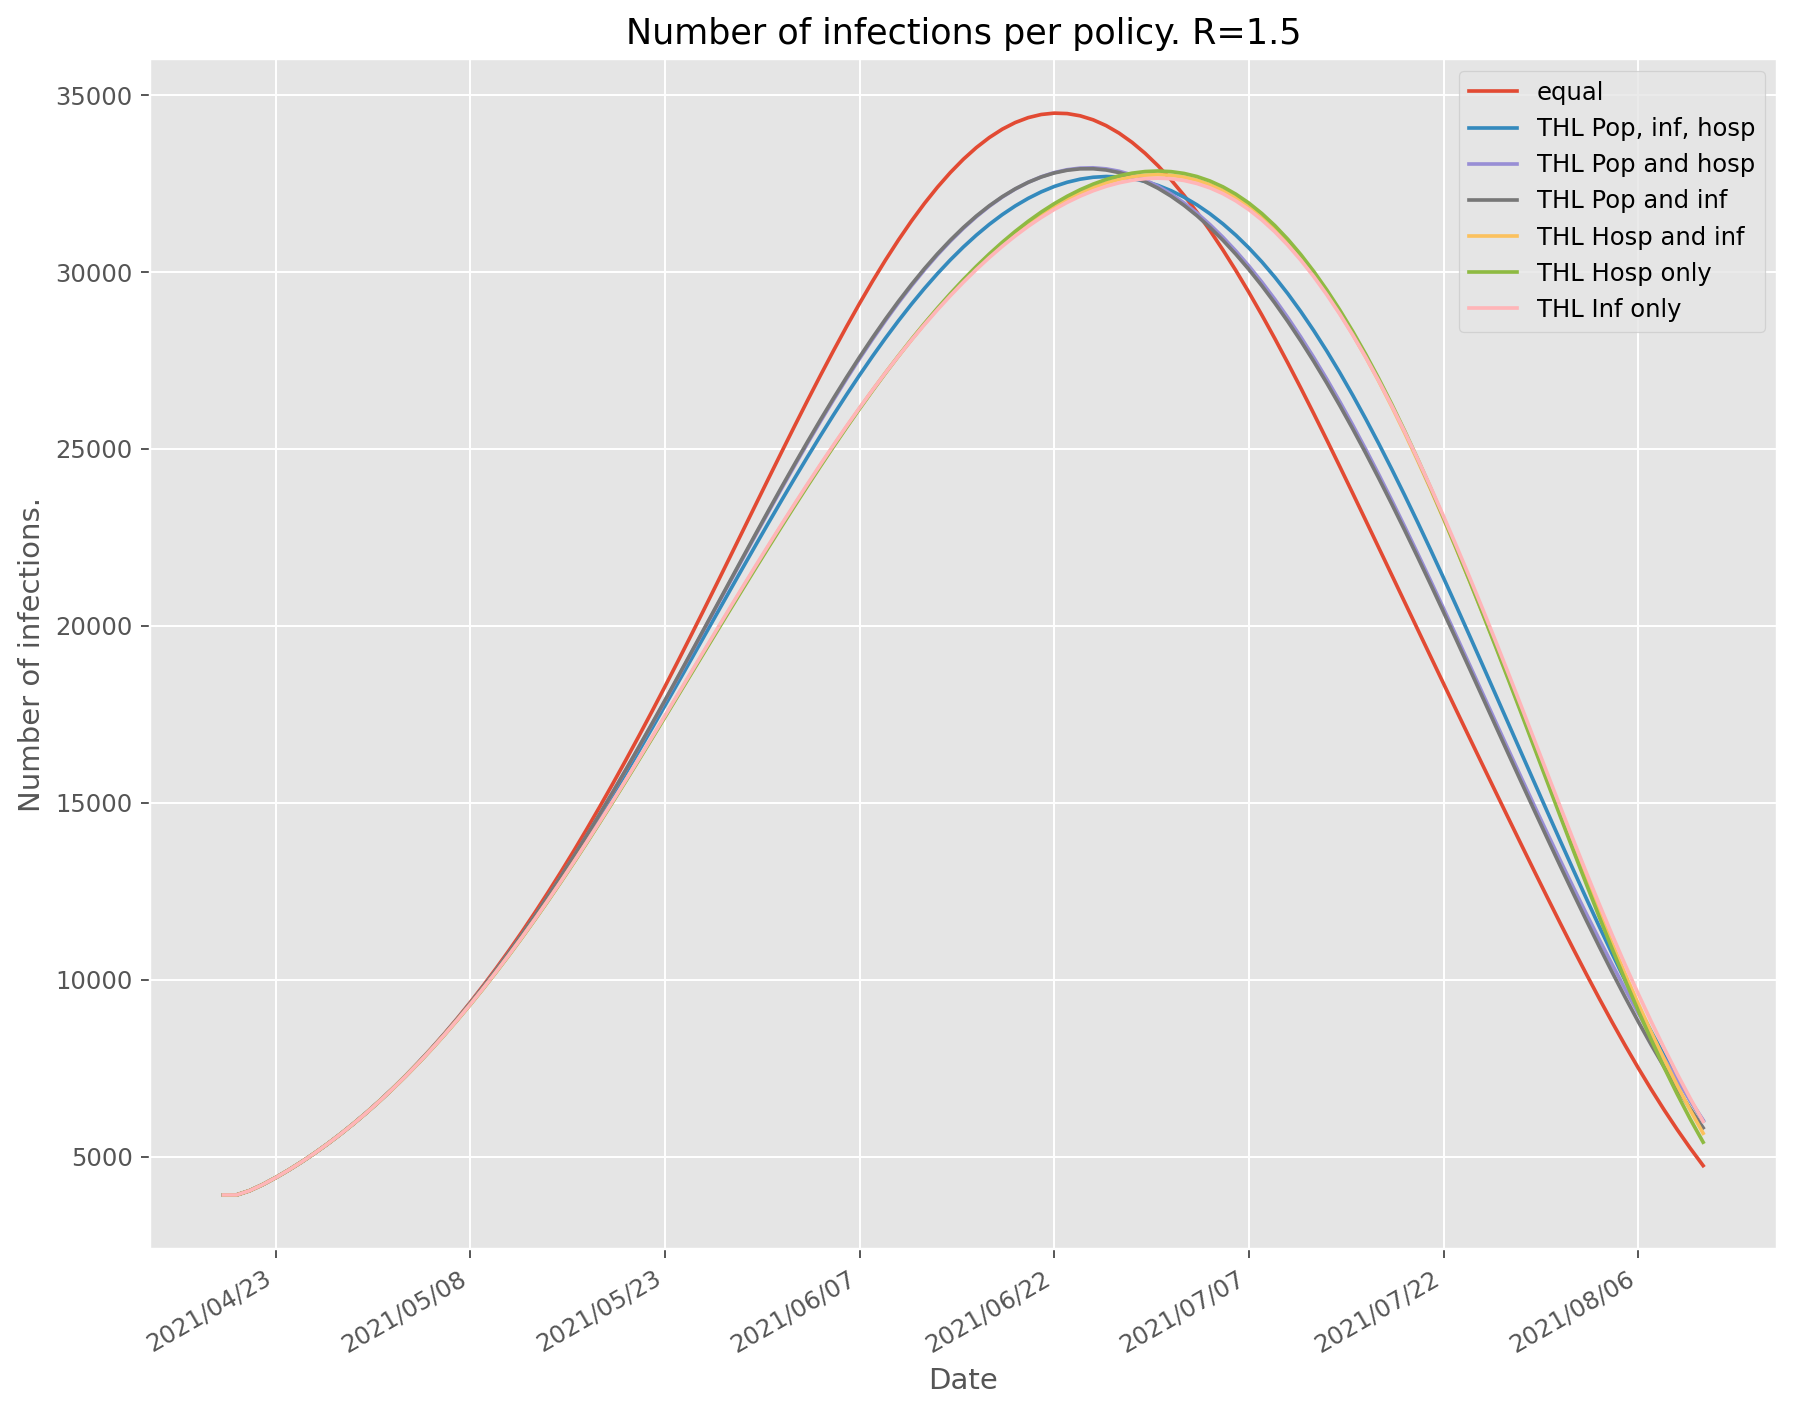

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()